In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aviral\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
train = pd.read_csv('train (1).csv')
test = pd.read_csv('test (1).csv')

In [3]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,...,12,4,2,13,8,4,2,4,4,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,8/6/04,...,0,0,1,0,1,1,1,0,0,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,10/10/14,...,5,9,1,5,4,3,6,3,1,0
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,3/9/12,...,0,0,1,0,0,1,0,0,0,0
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,2/5/09,...,0,0,1,0,0,1,0,0,0,0


# Visualizing the Target  Distribution

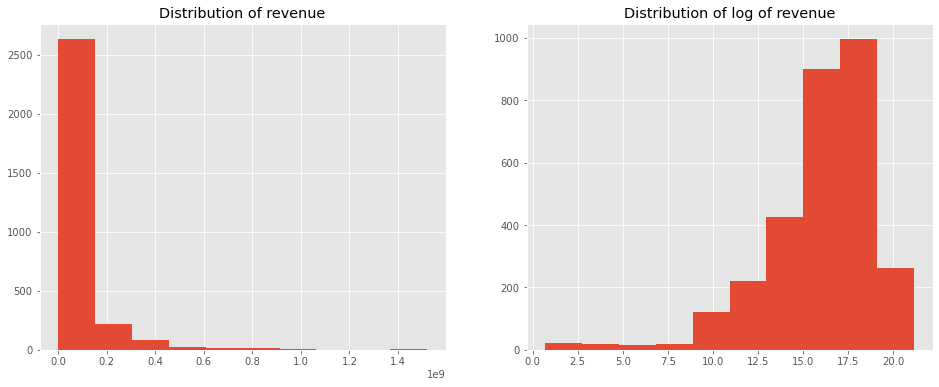

In [22]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

In [23]:
train['log_revenue'] = np.log1p(train['revenue'])

# Relationship between Film Revenue and Budget

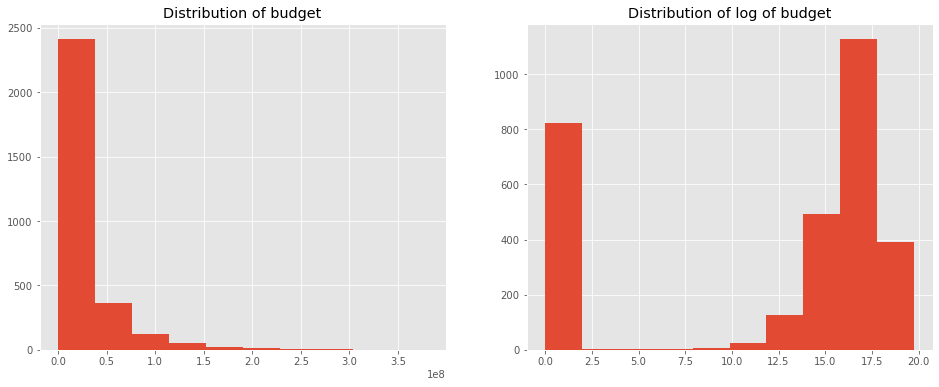

In [25]:
ig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

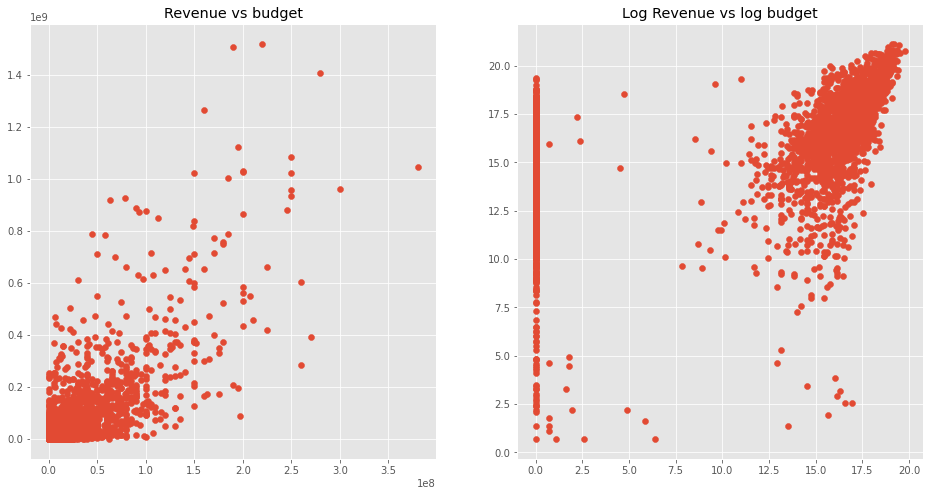

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

In [27]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

Does having an Official Homepage Affect Revenue

In [ ]:
train['homepage'].value_counts().head(10)

In [28]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

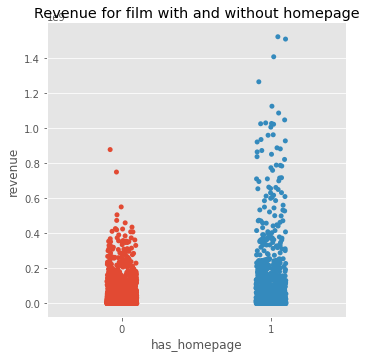

In [29]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

# Distribution of Languages in Film

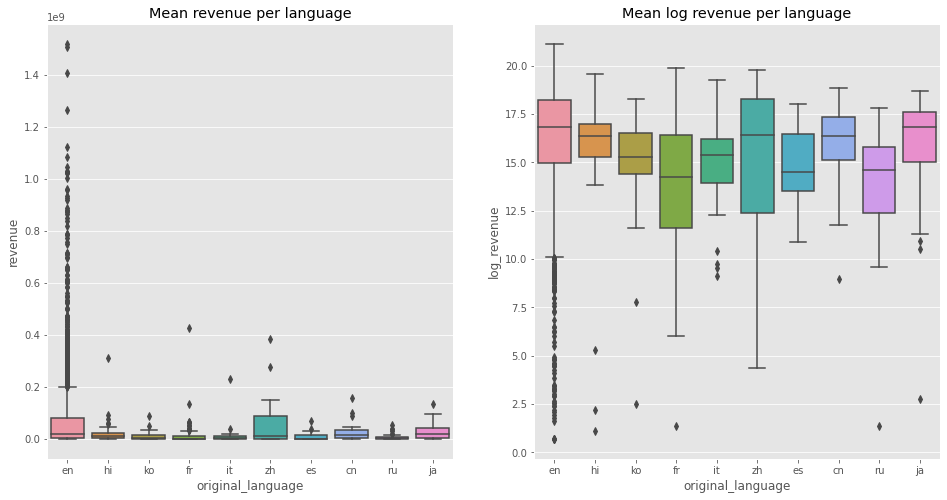

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

# Frequent Words in Film Titles and Descriptions

In [33]:
from wordcloud import WordCloud

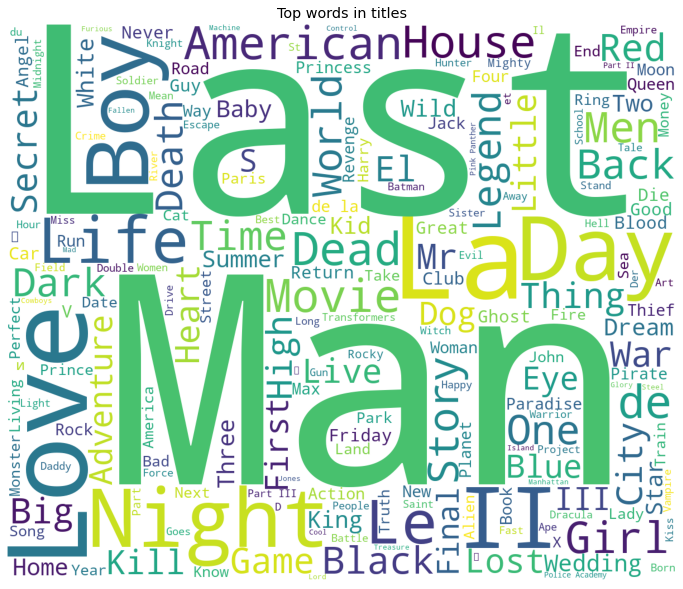

In [34]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

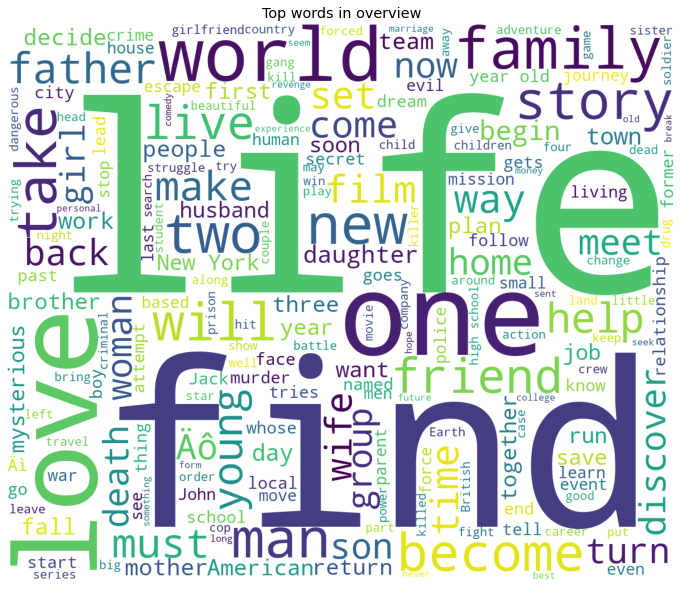

In [35]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

# Do Film Descriptions Impact Revenue?

In [47]:
import eli5

ModuleNotFoundError: No module named 'eli5'

In [48]:
import eli5
vectorizer=TfidfVectorizer(sublinear_tf=True,analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1, 2),min_df=5)
overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

SyntaxError: invalid non-printable character U+00A0 (Temp/ipykernel_22396/1031682969.py, line 6)

In [ ]:
# print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

# Analyzing Movie Release Dates

In [8]:
test.loc[test['release_date'].isnull() == False, 'release_date'].head()

0    7/14/07
1    5/19/58
2    5/23/97
3     9/4/10
4    2/11/05
Name: release_date, dtype: object

In [9]:
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

# Preprocessing  Features

In [10]:
test.loc[test['release_date'].isnull() == True].head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,departments_Art,departments_Crew,departments_Writing,departments_Costume & Make-Up,departments_Camera,departments_Directing,departments_Editing,departments_Visual Effects,departments_Lighting,departments_Actors
828,3829,0,NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '05/01/00'

In [12]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))

# Creating Features Based on Release Date 

In [13]:
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [14]:
def process_date(df):
    date_parts = ['year', 'weekday', 'month', 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + '_' + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    return df

train = process_date(train)
test = process_date(test)

C:\Users\Aviral\AppData\Local\Temp/ipykernel_22396/4242508006.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



# Visualize the Number of Films per Year with Plotly

In [15]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()

In [16]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

data = [go.Scatter(x=d1.index, y=d1.values, name='train'),
       go.Scatter(x=d2.index, y=d2.values, name='test')]
                  
layout = go.Layout(dict(title = 'Number of films per year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       ), legend = dict(orientation='v'))

py.iplot(dict(data=data, layout=layout))

# Number of Films and Revenue per Year

In [17]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'),
       go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
                  
layout = go.Layout(dict(title = 'Number of films and total revenue per year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       yaxis2 = dict(title = 'Total revenue', overlaying='y', side='right')), 
                   legend = dict(orientation='v'))

py.iplot(dict(data=data, layout=layout))

In [18]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()

data = [go.Scatter(x=d1.index, y=d1.values, name='film count'),
       go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
                  
layout = go.Layout(dict(title = 'Number of films and average revenue per year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       yaxis2 = dict(title = 'Average revenue', overlaying='y', side='right')), 
                   legend = dict(orientation='v'))

py.iplot(dict(data=data, layout=layout))

# Do Release Dates Impact Revenue?

Text(0.5, 1.0, 'Revenue of different days of the week')

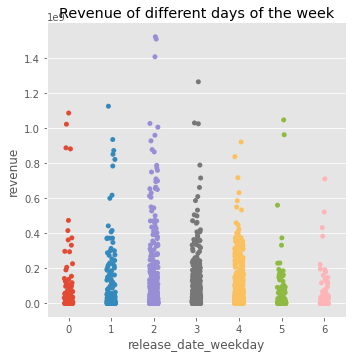

In [19]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue of different days of the week')

# Relationship between Runtime and Revenue

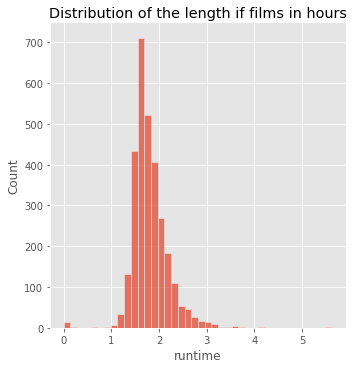

In [20]:
sns.displot(train['runtime'].fillna(0)/60, bins=40, kde=False);
plt.title('Distribution of the length if films in hours');

C:\Users\Aviral\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'runtime vs revenue')

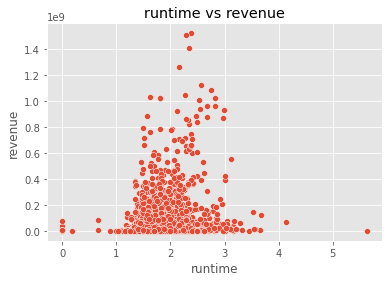

In [21]:
sns.scatterplot(train['runtime'].fillna(0)/60, train['revenue'])
plt.title('runtime vs revenue')